# Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestRegressor

#from pygam import LinearGAM
#from sklearn.neural_network import MLPRegressor
# from sklearn.svm import SVR
# import statsmodels.api as sm
# from sklearn.linear_model import Ridge

# Class

In [2]:
class MyDataSet:
    def __init__(self):
        self.significant_field = []
    
    def load_data(self):
        self.event = pd.read_csv("data/all_user_event_data.csv")
        self.profile = pd.read_csv("data/all_user_profile_data.csv")
        self.repo = pd.read_csv("data/all_user_repo_data.csv")
        self.starred = pd.read_csv("data/all_user_starred_data.csv")

    def fill_null(self):
        print("fill null in dataset...")
        for field in [self.profile["followers"], 
                      self.profile["following"], 
                      self.profile["public_repos"], 
                      self.profile["public_gists"], 
                      self.repo["stargazers_count"], 
                      self.repo["forks"], 
                      self.starred["stargazers_count"]
                     ]:
            field.fillna(0, inplace=True)

        for field in [self.profile["followers"], 
                      self.profile["following"],
                      self.repo["fork"]
                     ]:
            field.fillna(False, inplace=True)

    def remove_users_without_single_python_repo(self):
        print("remove users without a single python repository in dataset...")
        all_users = set(self.repo["user_alias"].unique())
        users_with_python = set(self.repo[self.repo["language"] == "Python"]["user_alias"].unique())
        users_without_python = list(all_users - users_with_python)
        self.event = self.event[~self.event["user_alias"].isin(users_without_python)]
        self.profile = self.profile[~self.profile["user_alias"].isin(users_without_python)]
        self.repo = self.repo[~self.repo["user_alias"].isin(users_without_python)]
        self.starred = self.starred[~self.starred["user_alias"].isin(users_without_python)]
        print(f"User before remove amount: {len(all_users)}")
        print(f"User after remove amount: {len(users_with_python)}")

    def clean_data(self):
        self.fill_null()
        self.remove_users_without_single_python_repo()

    def split_user_to_high_follower_and_low_follower(self):
        threshold = np.exp(4)
        self.high_follower_profile = self.profile[self.profile["followers"] > threshold]
        high_follower_aliases = self.high_follower_profile["user_alias"]
        self.low_follower_profile = self.profile[~self.profile["user_alias"].isin(high_follower_aliases)]
        print(f"High follower user amount: {len(self.high_follower_profile)}")
        print(f"Low follower user amount: {len(self.low_follower_profile)}")
        
    def select_numeric_column(self, df):
        return df.select_dtypes(include=[np.number])

    def plot_corr(self, df, title):
        corr = df.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr, annot=True, cmap="coolwarm")
        plt.title(title)
        plt.show()
        return corr

    def correlation_analysis(self, df_group, data_name, do_print):
        Y = "followers"
        pval_test = 0.05
        for df, title in df_group:
            col_num = len(self.select_numeric_column(df).columns.to_list())
            if col_num < 20:
                corr = self.plot_corr(self.select_numeric_column(df), f"Correlation Matrix of {title} Data")
            else:
                if not do_print == False:
                    print(f"cannot generate correlation matrix heatmap, since there are too many columns ({col_num} columns)")

            df_numeric = self.select_numeric_column(df)
            df_numeric_cols = df_numeric.columns.to_list()
            df_numeric_cols.remove(Y)
            x = df_numeric_cols
            
            print("\n")
            print(f"Correlation Matrix of {title} Data")
            print(f"{df_numeric.corr()}")
            print("\n")
            for field in x:
                correlation, p_value = stats.spearmanr(df[field], df[Y])
                if not do_print == False:
                    print(f"Correlation test using Spearman Between {field} and {Y}")
                    print("H0: ρ=0")
                    print("H1: ρ≠0")
                if p_value < pval_test and correlation > 0.1:
                    result = f"Accept H1; there is a statistically significant linear relationship between {field} and {Y} with correlation = {round(correlation, 3)}, since p-value = {round(p_value, 3)} which is < {pval_test}"
                    self.significant_field.append([data_name, field, correlation, p_value])
                else:
                    result = f"Fail to Reject H0; there is no significant relationship between {field} and {Y}, since p-value = {round(p_value, 3)} which is > {pval_test}"
                
                if not do_print == False:
                    print(result)
                    print("-"*150)

    def unstack_event_data(self):
        unstack_df = self.event.groupby(["user_alias", "event_type"]).size().unstack(fill_value=0)
        unstack_df.reset_index(inplace=True)
        self.event = unstack_df

    def convert_repo_type_data(self, repo_type, prefix):
        copy_df = repo_type.groupby("user_alias")[["description", "topics"]].apply(lambda x: x.notna().mean() * 100)
        try:
            copy_df_2 = repo_type.groupby("user_alias")[["stargazers_count", "forks"]].sum().reset_index()
        except:
            pass
        copy_df_3 = repo_type.groupby(["user_alias", "language"]).size().unstack(fill_value=0)
        total = copy_df_3.sum(axis=1)
        copy_df_3 = copy_df_3.div(total, axis=0)
        copy_df_3.reset_index(inplace=True)
        
        copy_df.columns = [prefix + "_" + col if col != "user_alias" else col for col in copy_df.columns]
        try:
            copy_df_2.columns = [prefix + "_" + col if col != "user_alias" else col for col in copy_df_2.columns]
            copy_df_3.columns = [prefix + "_" + col if col != "user_alias" else col for col in copy_df_3.columns]
            return_df = copy_df.merge(copy_df_2,on="user_alias").merge(copy_df_3,on="user_alias")
        except:
            copy_df_3.columns = [prefix + "_" + col if col != "user_alias" else col for col in copy_df_3.columns]
            return_df = copy_df.merge(copy_df_3,on="user_alias")
        return return_df

    def convert_repo_field_to_total_and_percentage_and_unstack(self):
        return self.convert_repo_type_data(self.repo, "repo")
        
    def convert_starred_field_to_total_and_percentage_and_unstack(self):
        return self.convert_repo_type_data(self.starred, "starred")
        
    def merge_follower_field_to(self, df):
        merged_df = pd.merge(self.profile[["user_alias", "followers"]], df, on="user_alias")
        return merged_df

    def merge_significant_field_to_one_dataset(self):
        df = self.profile.copy()
        df = df[["user_alias", "followers"]]
        
        for sig_field in self.significant_field:
            data_source = sig_field[0]
            field = sig_field[1]

            if data_source == "profile":
                df_source = self.profile
            elif data_source == "event":
                df_source = self.event
            elif data_source == "repo":
                df_source = self.repo
            elif data_source == "starred":
                df_source = self.starred

            df = pd.concat([df, df_source[field]], axis = 1)
        df.fillna(0, inplace=True)
        return df

    def plot_scatter(self, df, max_plot):
        Y = "followers"
        
        df_numeric = self.select_numeric_column(df)
        df_numeric_cols = df_numeric.columns.to_list()
        df_numeric_cols.remove(Y)
        x_ = df_numeric_cols
        count_plot = 0
        for field in x_:
            if count_plot >= max_plot:
                break
            count_plot += 1
            plt.figure(figsize=(10, 6))
            copy_df = df.copy()
            copy_df["user_type"] = ["high-follower user" if x > np.exp(4) else "low-follower user" for x in copy_df["followers"]]
            sns.scatterplot(x=field, y=Y, hue="user_type", data=copy_df)
            plt.title(f"Scatter plot between {Y} and {field}")
            plt.legend(loc="upper right")
            plt.show()


# Data Analysis

## Load And Clean Data

In [3]:
my_data_set = MyDataSet()

In [4]:
my_data_set.load_data()

In [5]:
my_data_set.clean_data()

fill null in dataset...
remove users without a single python repository in dataset...
User before remove amount: 8465
User after remove amount: 5520


In [6]:
my_data_set.split_user_to_high_follower_and_low_follower()

High follower user amount: 259
Low follower user amount: 5379


## Profile Data Correlation Analysis

In [7]:
my_data_set.profile.head()

,user_alias,type,hireable,location,followers,following,public_repos,public_gists,created_at,updated_at
3,usr3,User,True,Karachi,0.0,0.0,5.0,0.0,2021-09-24T09:04:40Z,2023-05-02T19:11:00Z
5,usr5,User,True,Remote,0.0,6.0,22.0,7.0,2022-06-02T04:04:01Z,2023-12-21T10:06:23Z
6,usr6,User,True,NaN,1.0,2.0,19.0,0.0,2021-08-20T19:03:28Z,2023-12-18T08:21:10Z
7,usr7,User,True,Iran,3.0,7.0,16.0,0.0,2021-06-03T12:52:25Z,2023-10-13T17:19:17Z
9,usr9,User,NaN,Kiev/Lviv,0.0,0.0,16.0,0.0,2019-04-03T19:46:09Z,2023-03-13T20:20:03Z


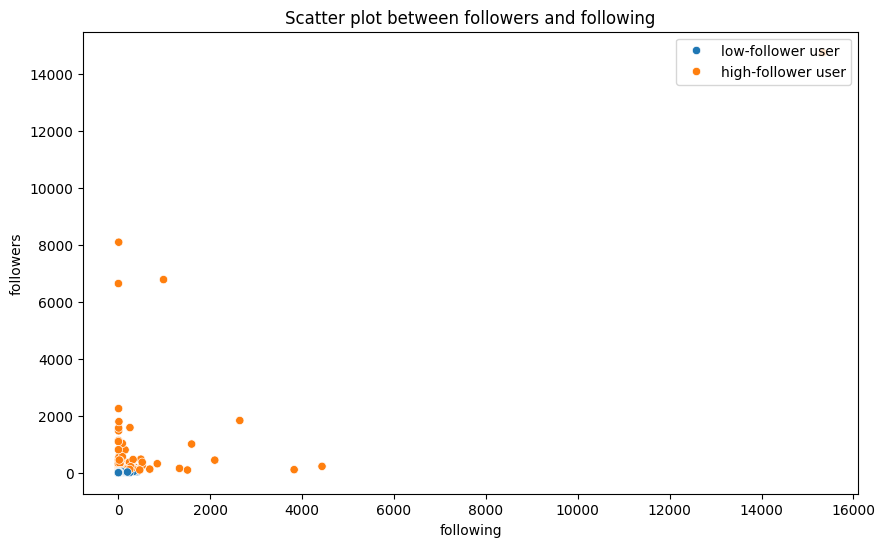

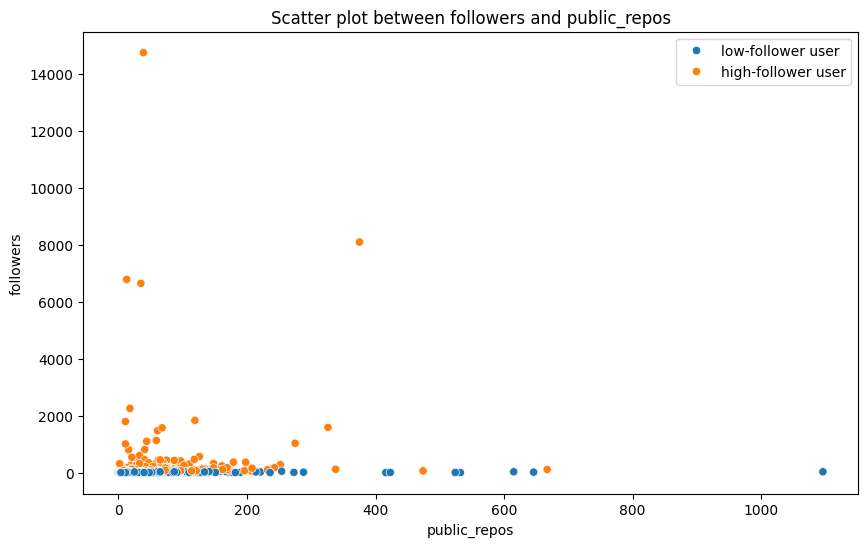

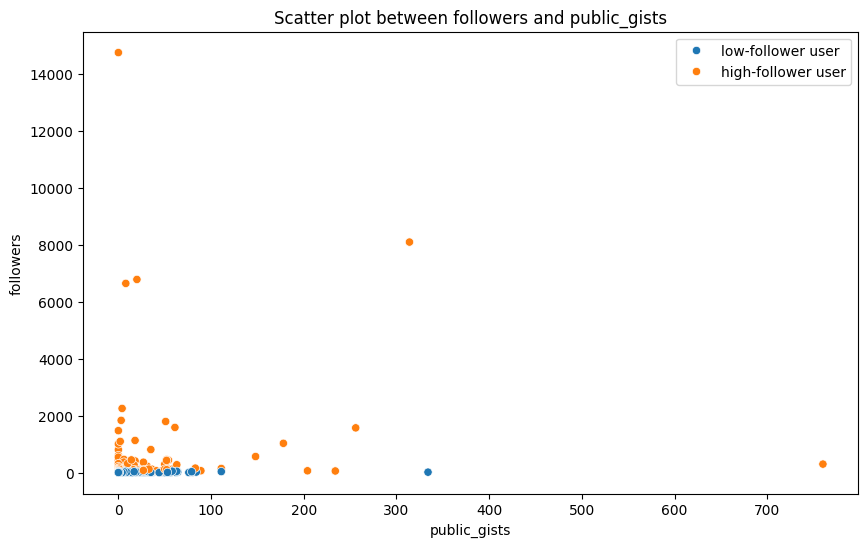

In [8]:
my_data_set.plot_scatter(my_data_set.profile, 3)

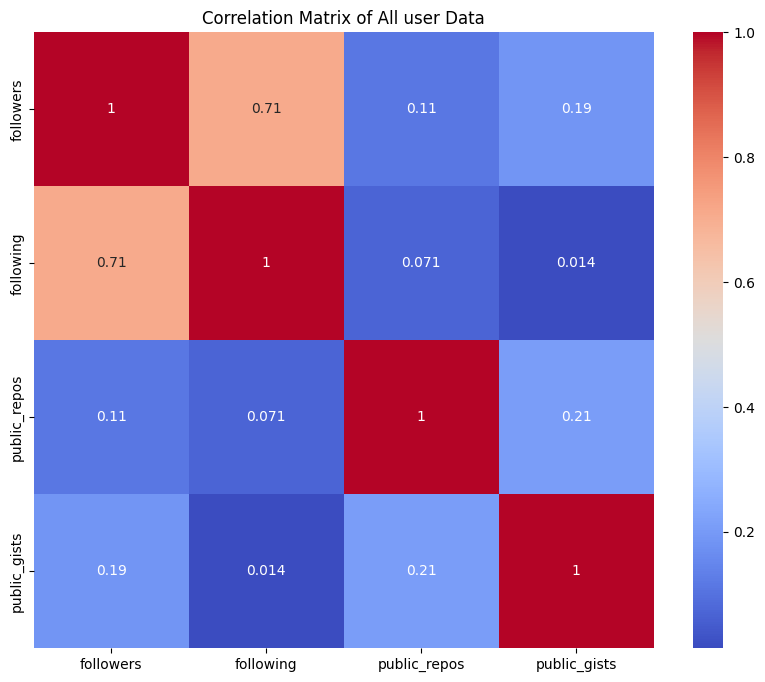



Correlation Matrix of All user Data
              followers  following  public_repos  public_gists
followers      1.000000   0.710451      0.110147      0.186690
following      0.710451   1.000000      0.071278      0.013650
public_repos   0.110147   0.071278      1.000000      0.209447
public_gists   0.186690   0.013650      0.209447      1.000000


Correlation test using Spearman Between following and followers
H0: ρ=0
H1: ρ≠0
Accept H1; there is a statistically significant linear relationship between following and followers with correlation = 0.781, since p-value = 0.0 which is < 0.05
------------------------------------------------------------------------------------------------------------------------------------------------------
Correlation test using Spearman Between public_repos and followers
H0: ρ=0
H1: ρ≠0
Accept H1; there is a statistically significant linear relationship between public_repos and followers with correlation = 0.54, since p-value = 0.0 which is < 0.05
-----

In [9]:
my_data_set.correlation_analysis(
    [[my_data_set.profile, "All user"]], "profile", True
)

## Event Data Correlation Analysis

In [10]:
my_data_set.unstack_event_data()

In [11]:
my_data_set.event = my_data_set.merge_follower_field_to(my_data_set.event)

In [12]:
my_data_set.event.head()

,user_alias,followers,CommitCommentEvent,CreateEvent,DeleteEvent,ForkEvent,GollumEvent,IssueCommentEvent,IssuesEvent,MemberEvent,PublicEvent,PullRequestEvent,PullRequestReviewCommentEvent,PullRequestReviewEvent,PushEvent,ReleaseEvent,WatchEvent
0,usr5,0.0,0,6,0,0,0,0,1,0,0,0,0,0,4,0,1
1,usr6,1.0,0,8,1,0,0,1,1,2,2,1,0,0,220,1,2
2,usr10,126.0,0,0,0,1,0,1,0,0,0,0,0,0,4,0,189
3,usr11,7.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,usr14,8.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


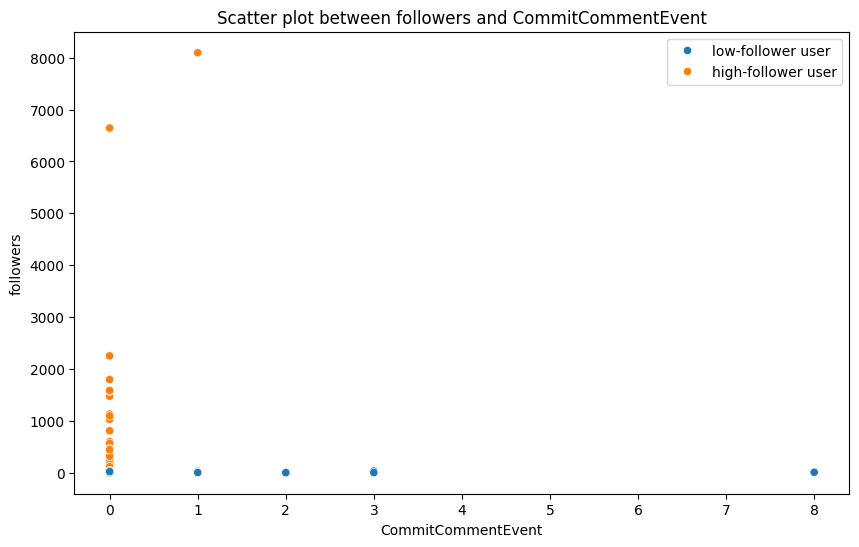

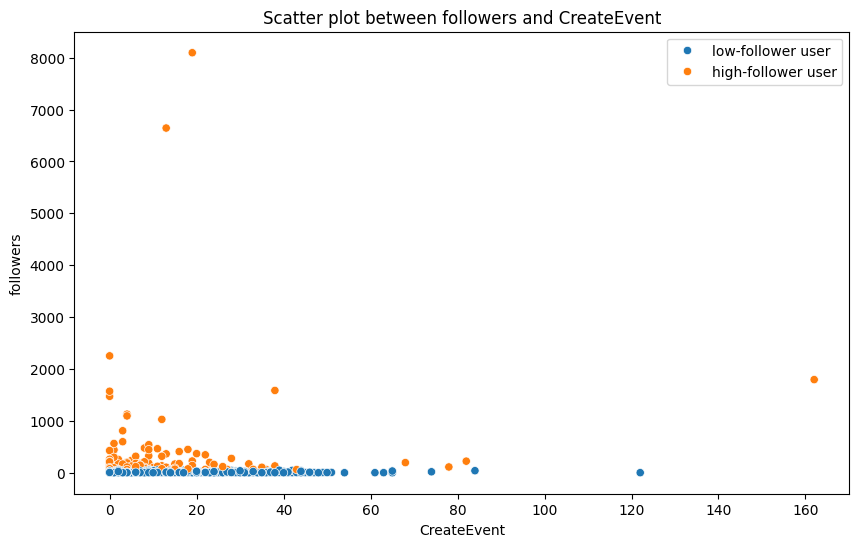

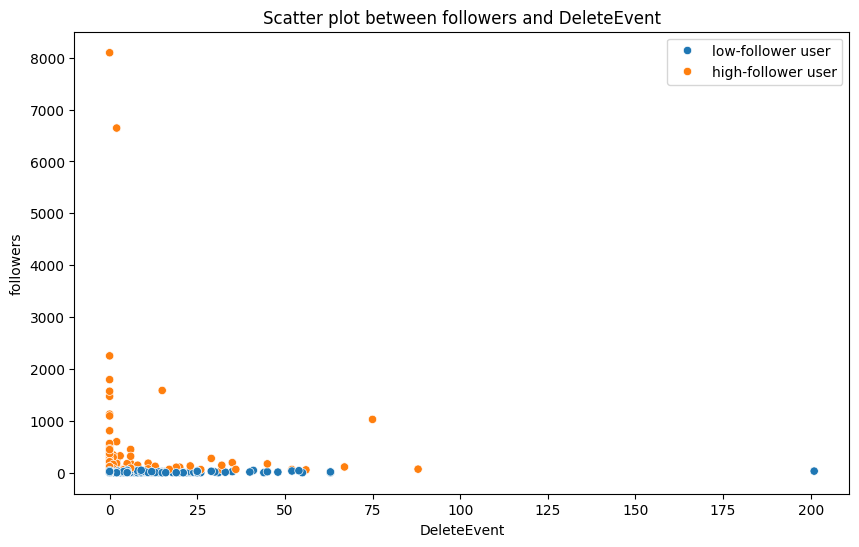

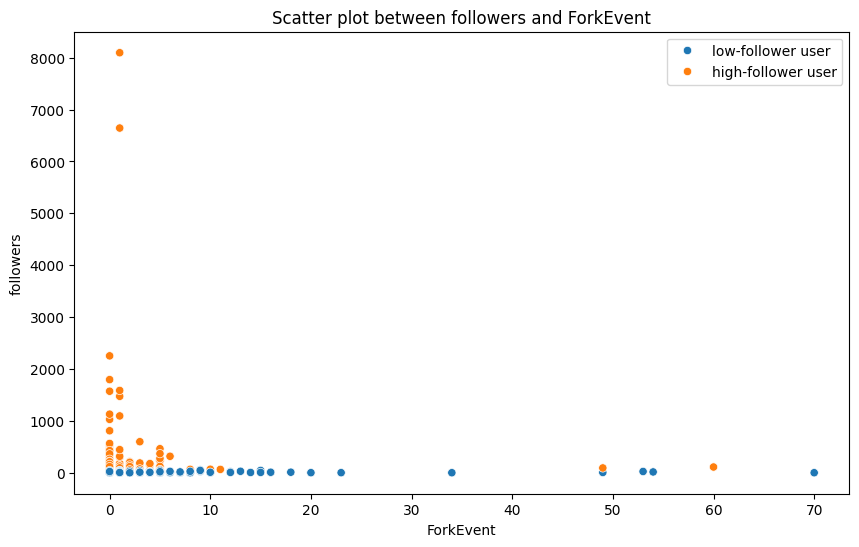

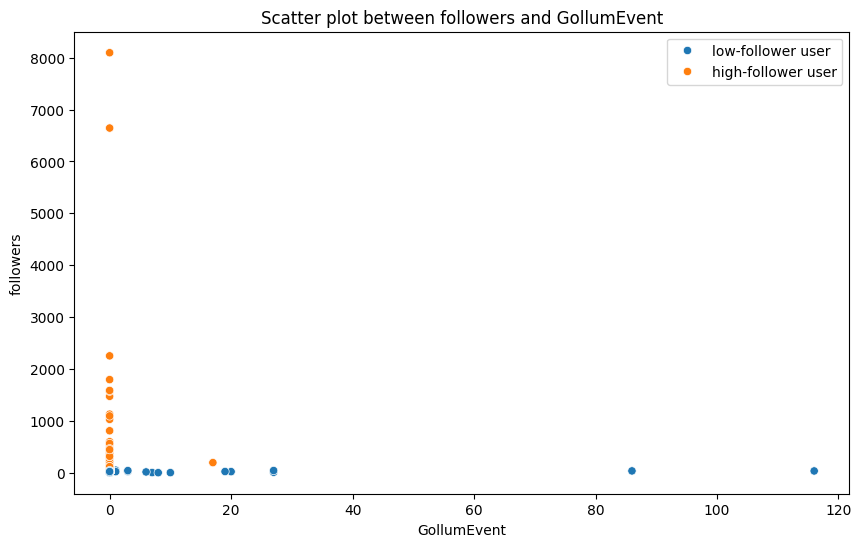

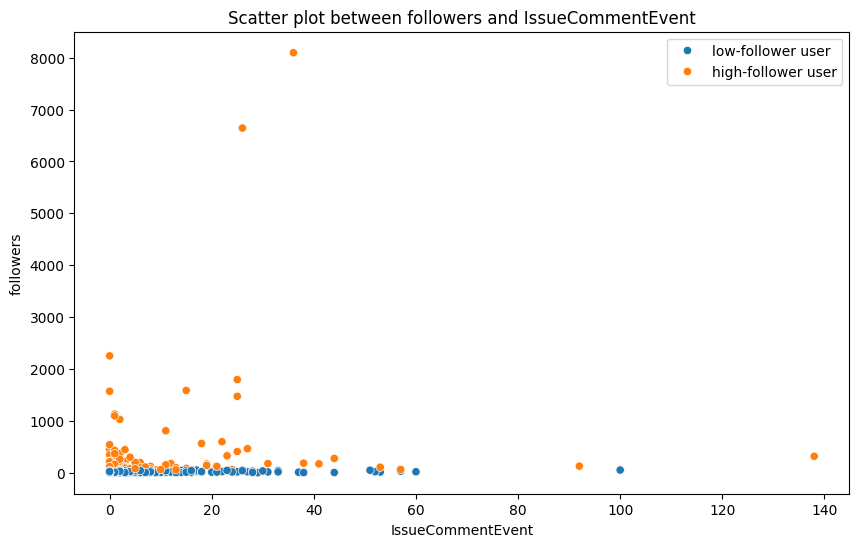

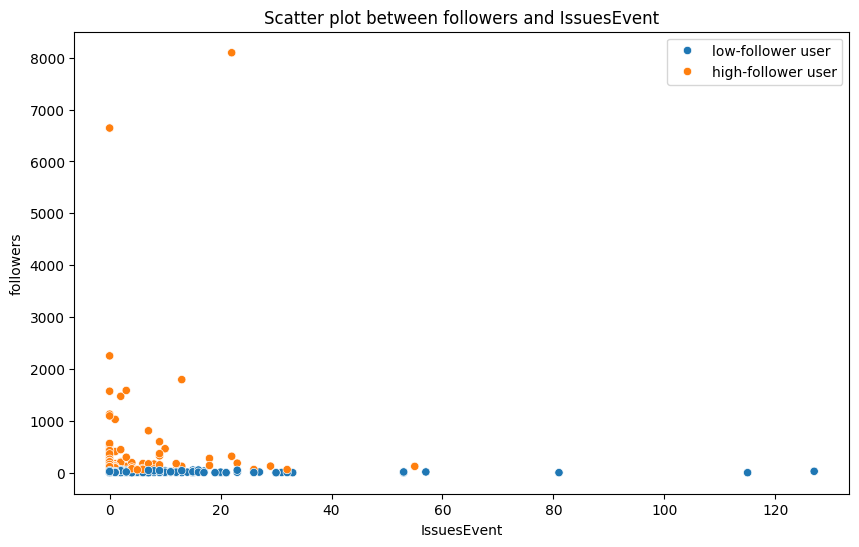

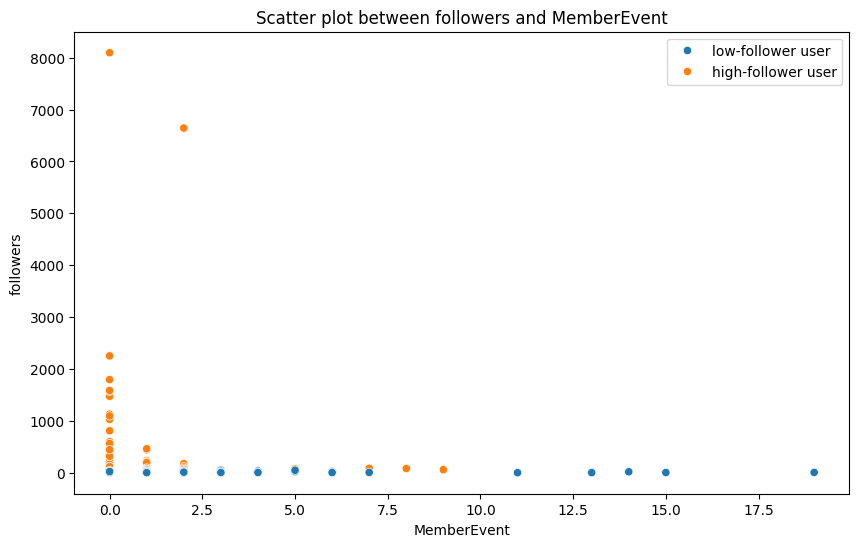

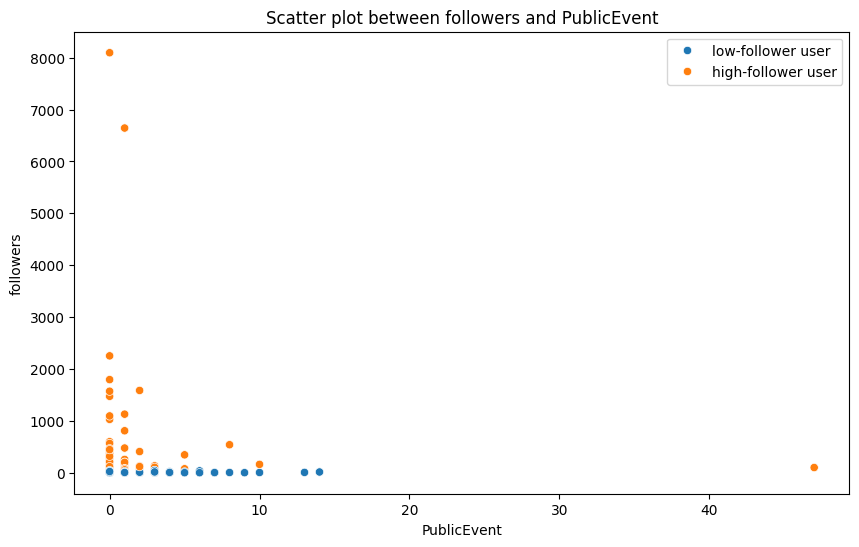

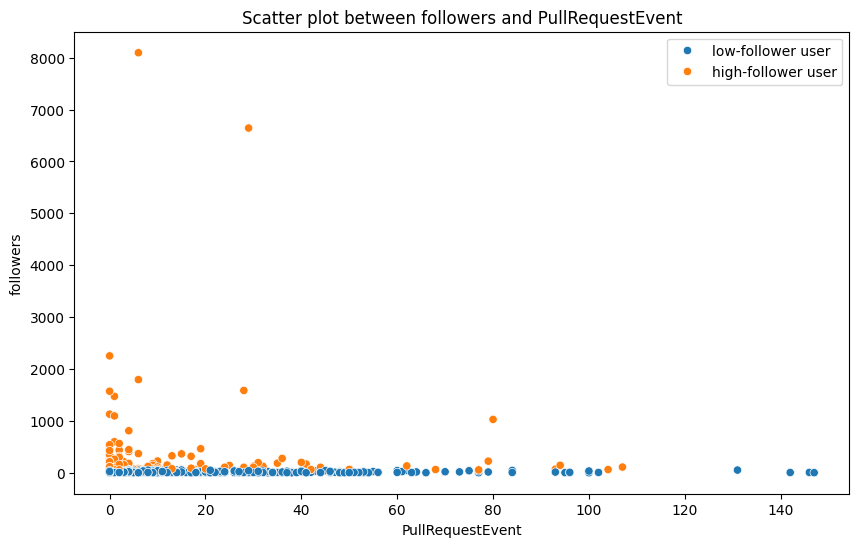

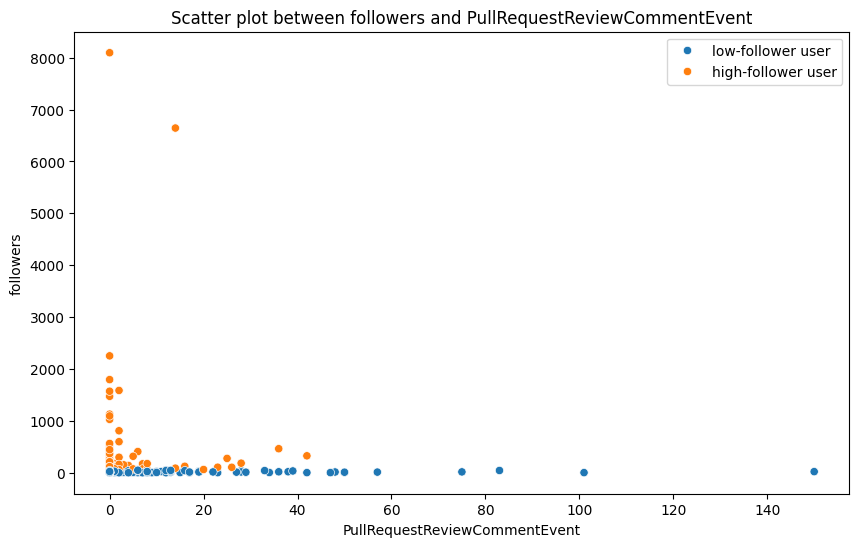

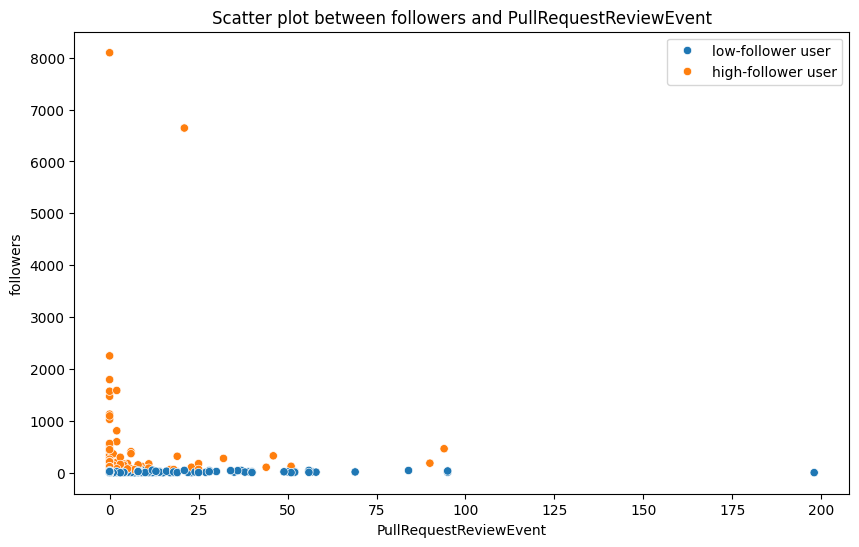

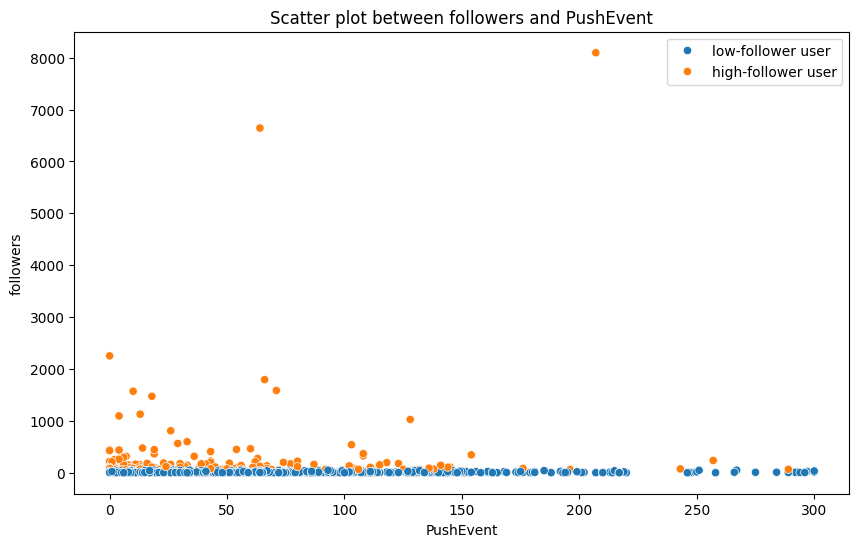

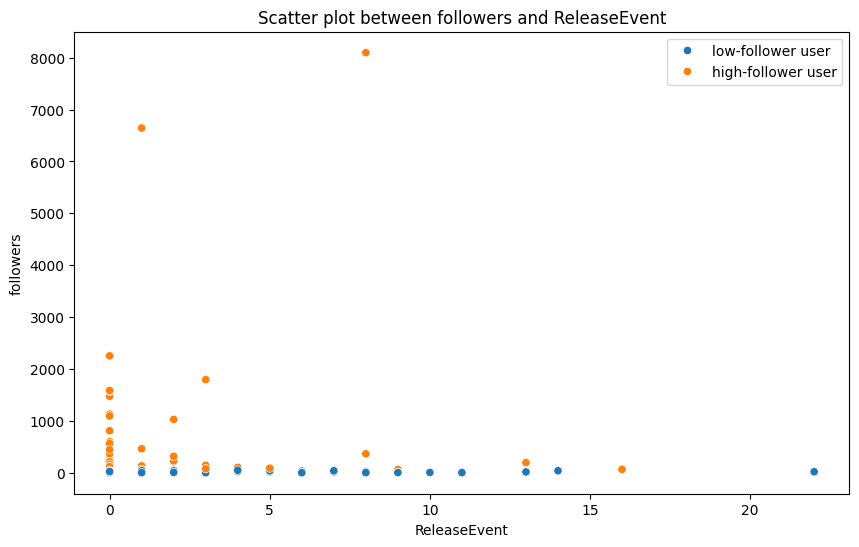

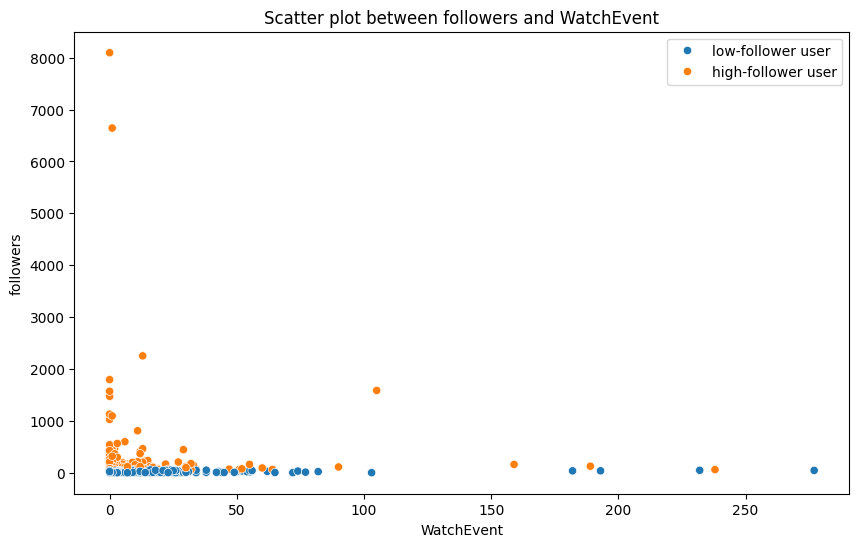

In [13]:
my_data_set.plot_scatter(my_data_set.event, 15)

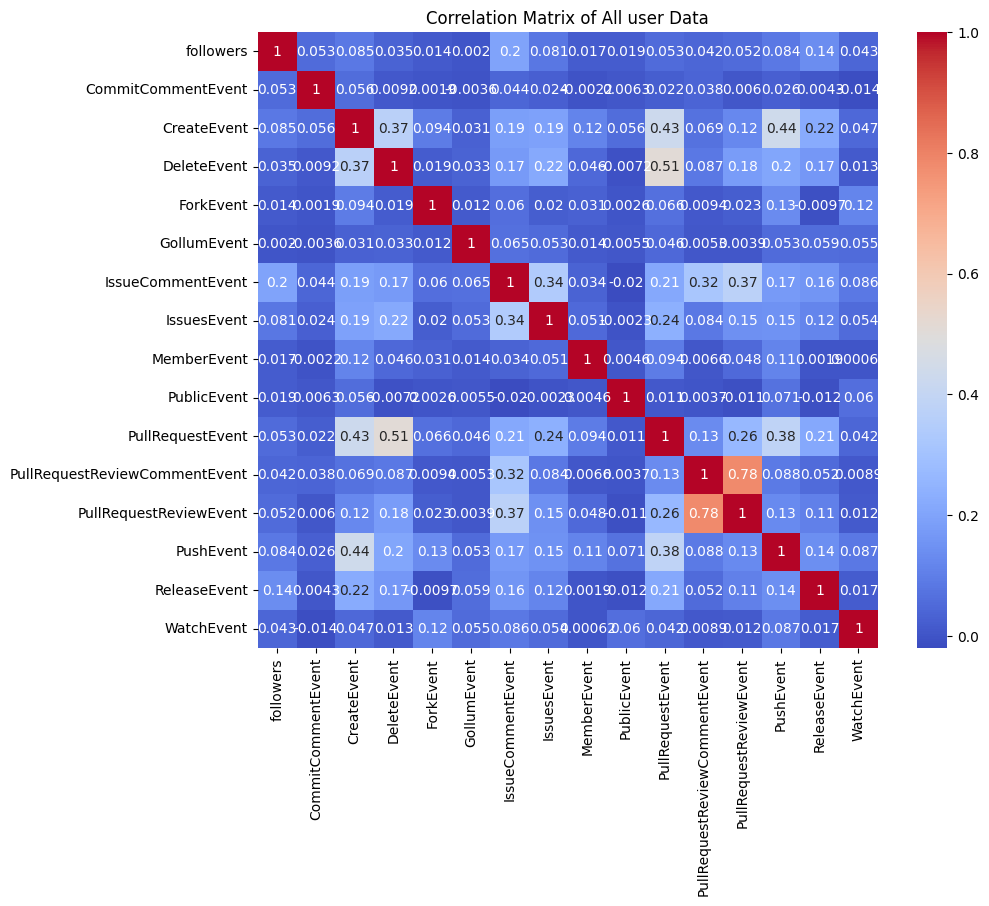



Correlation Matrix of All user Data
                               followers  CommitCommentEvent  CreateEvent  \
followers                       1.000000            0.053358     0.084811   
CommitCommentEvent              0.053358            1.000000     0.055686   
CreateEvent                     0.084811            0.055686     1.000000   
DeleteEvent                     0.034912            0.009233     0.369372   
ForkEvent                       0.013728            0.001902     0.093514   
GollumEvent                     0.002045           -0.003595     0.030713   
IssueCommentEvent               0.197129            0.043509     0.185052   
IssuesEvent                     0.081248            0.023898     0.191754   
MemberEvent                     0.017220           -0.002193     0.115235   
PublicEvent                     0.019127            0.006342     0.055970   
PullRequestEvent                0.052868            0.022489     0.427378   
PullRequestReviewCommentEvent   0.0419

In [14]:
my_data_set.correlation_analysis(
    [[my_data_set.event, "All user"]], "event", True
)

## Repo Data Correlation Analysis

In [15]:
my_data_set.repo = my_data_set.convert_repo_field_to_total_and_percentage_and_unstack()

In [16]:
my_data_set.repo = my_data_set.merge_follower_field_to(my_data_set.repo)

In [17]:
my_data_set.repo.head()

,user_alias,followers,repo_description,repo_topics,repo_stargazers_count,repo_forks,repo_1C Enterprise,repo_AGS Script,repo_AMPL,repo_API Blueprint,...,repo_YAML,repo_YARA,repo_YASnippet,repo_Yacc,repo_Zig,repo_kvlang,repo_mcfunction,repo_nesC,repo_reStructuredText,repo_xBase
0,usr3,0.0,100.000000,40.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,usr5,0.0,31.818182,0.00,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,usr6,1.0,52.631579,0.00,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,usr7,3.0,81.250000,6.25,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,usr9,0.0,68.750000,6.25,3.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


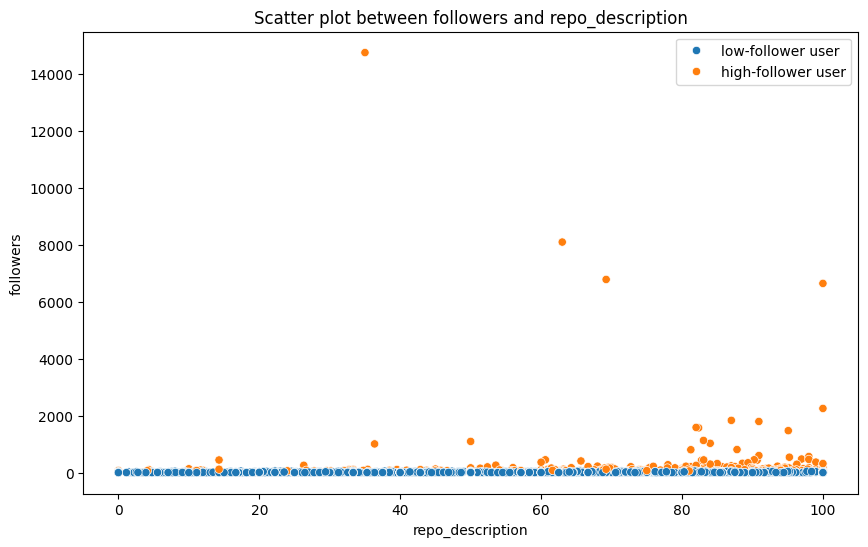

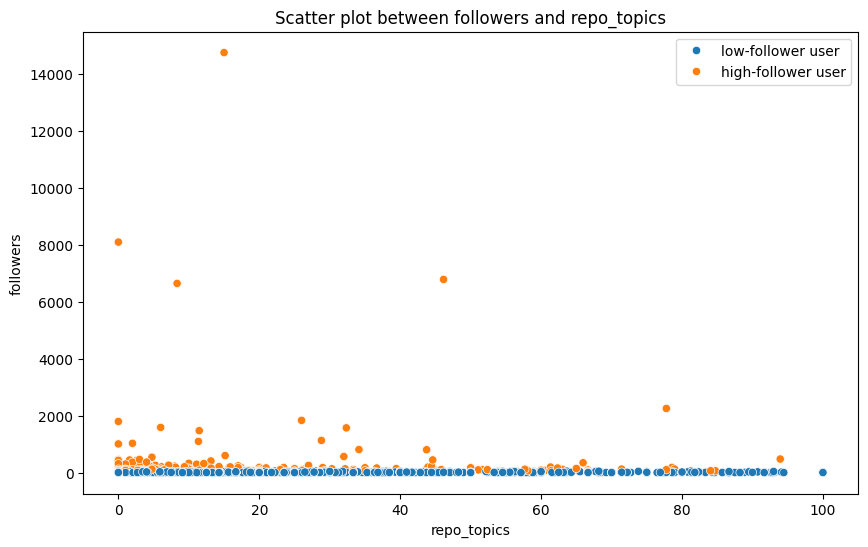

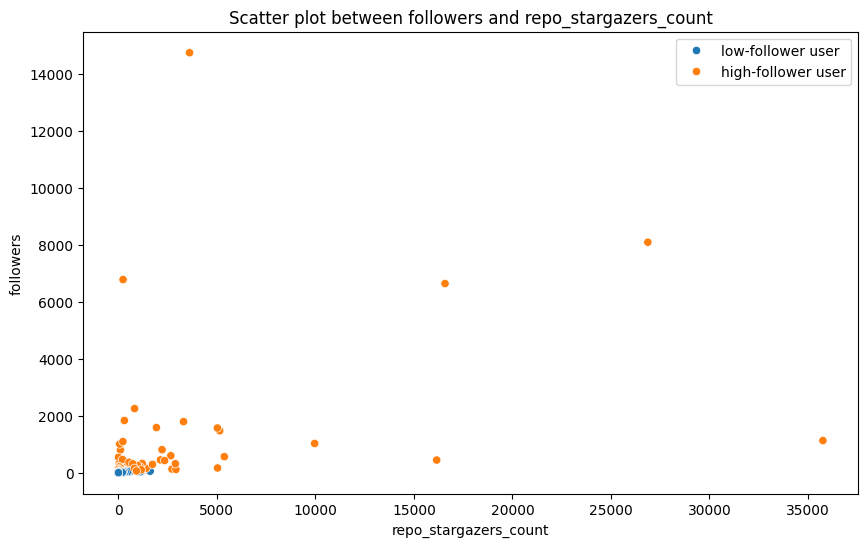

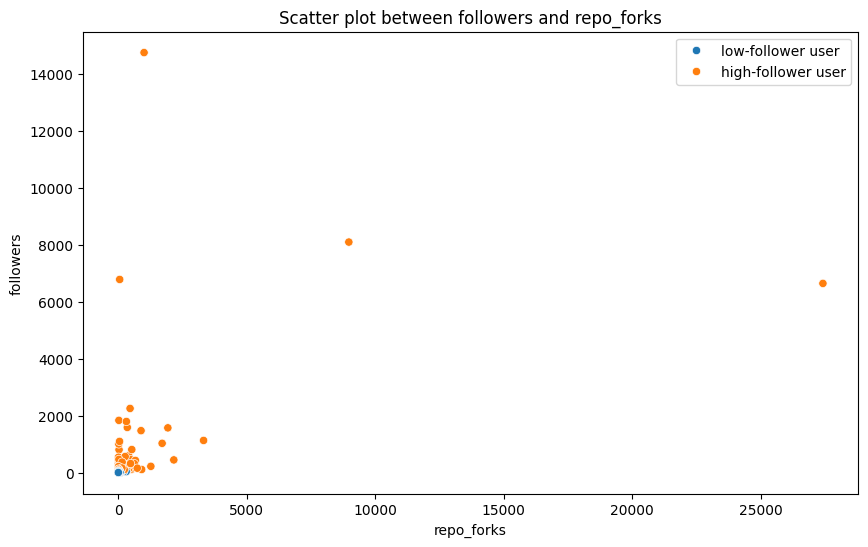

In [18]:
my_data_set.plot_scatter(my_data_set.repo, 4)

In [19]:
my_data_set.correlation_analysis(
    [[my_data_set.repo, "All user"]], "repo", False
)



Correlation Matrix of All user Data
                       followers  repo_description  repo_topics  \
followers               1.000000          0.035356     0.037762   
repo_description        0.035356          1.000000     0.320054   
repo_topics             0.037762          0.320054     1.000000   
repo_stargazers_count   0.449443          0.050500     0.036145   
repo_forks              0.484092          0.035414     0.010964   
...                          ...               ...          ...   
repo_kvlang            -0.002106         -0.004987     0.003088   
repo_mcfunction        -0.000970         -0.004923     0.005062   
repo_nesC               0.001321         -0.010322    -0.005287   
repo_reStructuredText   0.002766          0.016759    -0.005449   
repo_xBase             -0.000323         -0.008960    -0.006240   

                       repo_stargazers_count  repo_forks  repo_1C Enterprise  \
followers                           0.449443    0.484092           -0.000993 

## Starred Repo Data Correlation Analysis

In [20]:
my_data_set.starred = my_data_set.convert_starred_field_to_total_and_percentage_and_unstack()

In [21]:
my_data_set.starred = my_data_set.merge_follower_field_to(my_data_set.starred)

In [22]:
my_data_set.starred.head()

,user_alias,followers,starred_description,starred_topics,starred_1C Enterprise,starred_AGS Script,starred_ANTLR,starred_ASL,starred_ASP,starred_ASP.NET,...,starred_YAML,starred_YARA,starred_Yacc,starred_ZenScript,starred_Zig,starred_hoon,starred_kvlang,starred_reStructuredText,starred_sed,starred_wdl
0,usr5,0.0,100.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,usr6,1.0,88.888889,88.888889,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,usr7,3.0,88.888889,66.666667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,usr10,126.0,100.000000,95.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.010309,0.0,0.0,0.0,0.0,0.0
4,usr11,7.0,100.000000,58.974359,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


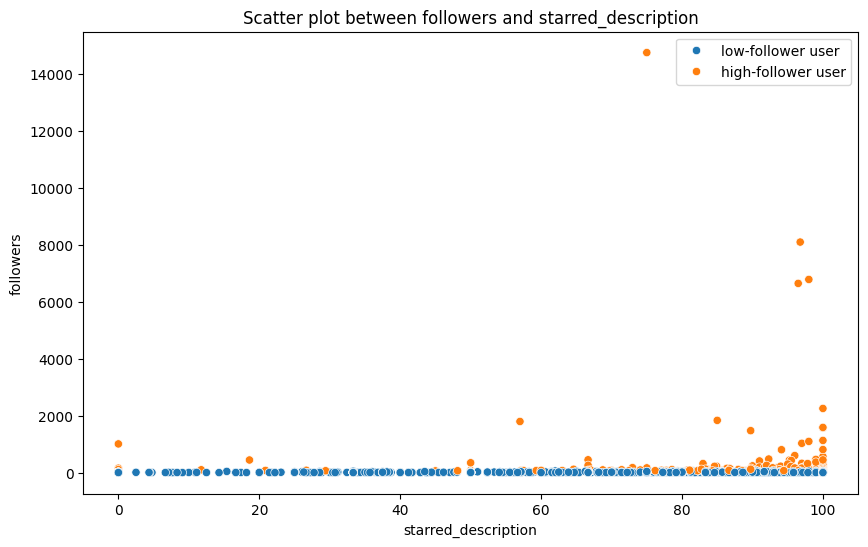

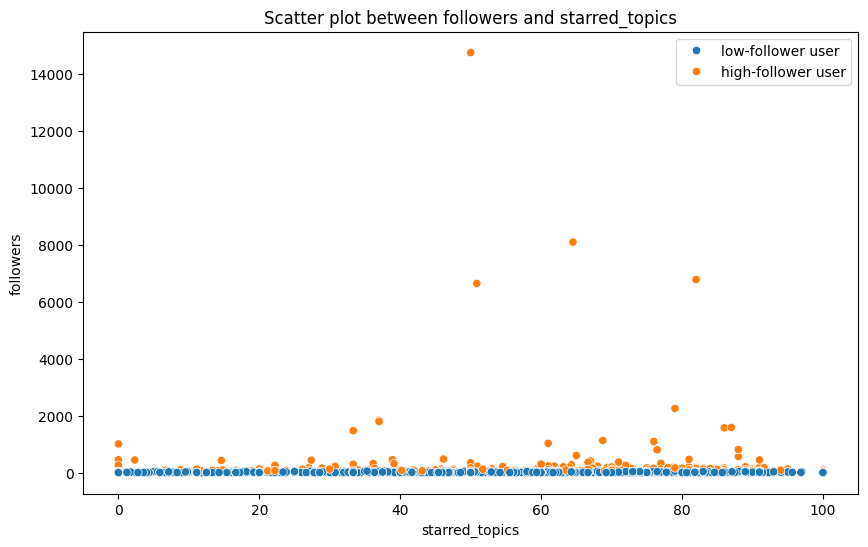

In [23]:
my_data_set.plot_scatter(my_data_set.starred, 2)

In [24]:
my_data_set.correlation_analysis(
    [[my_data_set.starred, "All user"]], "starred", False
)



Correlation Matrix of All user Data
                          followers  starred_description  starred_topics  \
followers                  1.000000             0.015912        0.024271   
starred_description        0.015912             1.000000        0.548683   
starred_topics             0.024271             0.548683        1.000000   
starred_1C Enterprise     -0.001213             0.010340        0.015749   
starred_AGS Script         0.002150             0.010568        0.000534   
...                             ...                  ...             ...   
starred_hoon               0.006174             0.010340        0.016765   
starred_kvlang            -0.002025            -0.014093       -0.034166   
starred_reStructuredText   0.000221             0.016405        0.002682   
starred_sed               -0.000564             0.007126        0.006544   
starred_wdl               -0.001463             0.003412       -0.006356   

                          starred_1C Enterprise  

## Field That Have Statistically Significant Linear Relationship With Followers

In [25]:
print("i, data, field, corr, pvalue")
for i, sig_field in enumerate(my_data_set.significant_field):
    print(f"{i}, {sig_field[0]}, {sig_field[1]}, {round(sig_field[2], 5)}, {round(sig_field[3], 5)}")

i, data, field, corr, pvalue
0, profile, following, 0.78069, 0.0
1, profile, public_repos, 0.54035, 0.0
2, profile, public_gists, 0.37167, 0.0
3, event, DeleteEvent, 0.14556, 0.0
4, event, ForkEvent, 0.18432, 0.0
5, event, IssueCommentEvent, 0.30588, 0.0
6, event, IssuesEvent, 0.23289, 0.0
7, event, PullRequestEvent, 0.21409, 0.0
8, event, PullRequestReviewCommentEvent, 0.18661, 0.0
9, event, PullRequestReviewEvent, 0.21252, 0.0
10, event, ReleaseEvent, 0.13468, 0.0
11, event, WatchEvent, 0.36205, 0.0
12, repo, repo_description, 0.2335, 0.0
13, repo, repo_topics, 0.27476, 0.0
14, repo, repo_stargazers_count, 0.63503, 0.0
15, repo, repo_forks, 0.5661, 0.0
16, repo, repo_C, 0.24209, 0.0
17, repo, repo_C#, 0.13628, 0.0
18, repo, repo_C++, 0.21842, 0.0
19, repo, repo_CSS, 0.16834, 0.0
20, repo, repo_Dart, 0.12653, 0.0
21, repo, repo_Dockerfile, 0.12498, 0.0
22, repo, repo_Go, 0.21296, 0.0
23, repo, repo_Java, 0.16523, 0.0
24, repo, repo_JavaScript, 0.24621, 0.0
25, repo, repo_Kotlin, 0.105

## Multiple Linear Regression

In [26]:
my_data_set.sig_field_df = my_data_set.merge_significant_field_to_one_dataset()

In [27]:
my_data_set.sig_field_df.head()

,user_alias,followers,following,public_repos,public_gists,DeleteEvent,ForkEvent,IssueCommentEvent,IssuesEvent,PullRequestEvent,...,starred_Scala,starred_Shell,starred_Svelte,starred_Swift,starred_TeX,starred_TypeScript,starred_V,starred_Vim Script,starred_Vue,starred_Zig
3,usr3,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.020619,0.000000,0.0,0.020619,0.0,0.237113,0.010309,0.010309,0.000000,0.010309
5,usr5,0.0,6.0,22.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
6,usr6,1.0,2.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
7,usr7,3.0,7.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
9,usr9,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.016949,0.0,0.000000,0.0,0.016949,0.000000,0.000000,0.050847,0.000000


In [28]:
Q1 = my_data_set.sig_field_df["followers"].quantile(0.25)
Q3 = my_data_set.sig_field_df["followers"].quantile(0.75)
IQR = Q3 - Q1

outlier_threshold = Q3 + 6 * IQR

In [29]:
my_data_set.sig_field_df_filtered = my_data_set.sig_field_df[my_data_set.sig_field_df["followers"] < outlier_threshold]

In [30]:
len(my_data_set.sig_field_df_filtered)

7178

In [31]:
y = my_data_set.sig_field_df_filtered["followers"]
X = my_data_set.sig_field_df_filtered.drop(["user_alias", "followers"], axis=1)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [33]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = X_train_scaled.copy()
X_test = X_test_scaled.copy()

In [34]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### Evaluation

In [35]:
r_squared = model.score(X_test, y_test)

In [36]:
r_squared

0.5112433448361106

In [37]:
predicted_values = model.predict(X_test)

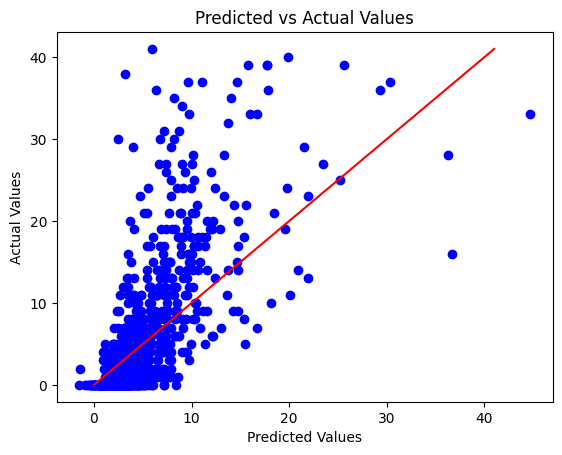

In [38]:
plt.scatter(predicted_values, y_test, color="blue")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Predicted vs Actual Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red")
plt.show()

### Plot Residual

In [39]:
y_train_pred = model.predict(X_train)

In [40]:
residuals = y_train - y_train_pred

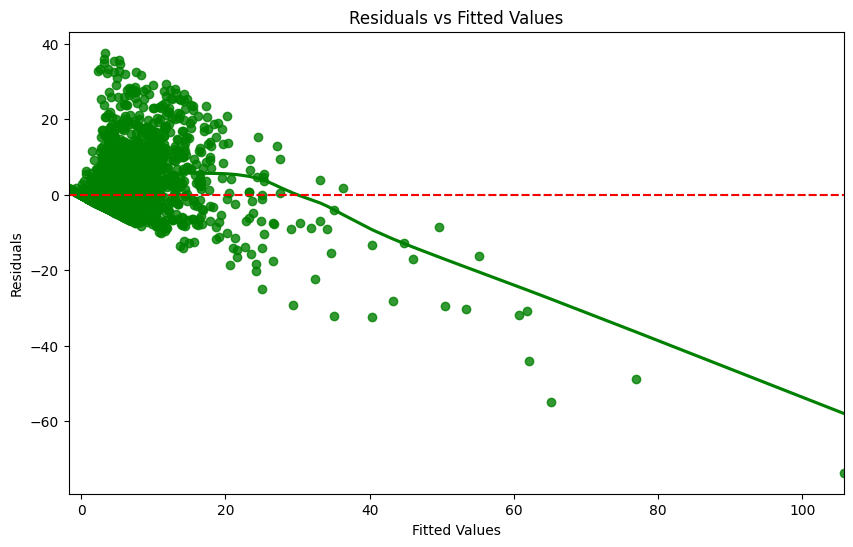

In [41]:
plt.figure(figsize=(10, 6))
sns.residplot(x=y_train_pred, y=residuals, lowess=True, color="g")
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

From Residuals vs Fitted Values Plot, There is a problem with this model; 
1. The residuals is drifting down with fitted values
2. The Y-Axis is unbalanced. (Most of data dot are gathering above 0)
3. The X-Axis is unbalanced. (Most of data dot are gathering around 0 to 20)

So, Reject the assumption of this model.

### Improve Model

#### Method Which Are Unable To Improve Model

In [42]:
# # Boxcox Transformation

# y_train_positive = y_train + 1
# y_train_transformed, lambda_optimal = stats.boxcox(y_train_positive)

# model = LinearRegression()
# model.fit(X_train, y_train_transformed)

In [43]:
# # Logarithmic Transformation

# y_train_positive = y_train + 1
# y_train_transformed = np.log2(y_train_positive)
# y_test_positive = y_test + 1
# y_test_transformed = np.log2(y_test_positive)

# model = LinearRegression()
# model.fit(X_train, y_train_transformed)

In [44]:
# # Weighted Regression

# X_train = sm.add_constant(X_train)
# X_test = sm.add_constant(X_test)

# y_train_positive = y_train + 1
# y_test_positive = y_test + 1

# weights = 1. / y_train_positive

# model = sm.WLS(y_train_positive, X_train, weights=weights)

# results = model.fit()
# r_squared = results.rsquared

# predicted_values = results.predict(X_test)

In [45]:
# # Ridge Regression

# ridge = Ridge(alpha = 10.0)

# ridge.fit(X_train, y_train)

# r_squared = ridge.score(X_test, y_test)

# predicted_values = ridge.predict(X_test)

#### Method Which Are Able to improve model but unable to intepret relationship 

In [46]:
# # Support Vector Machine

# model = SVR(kernel="linear")
# model.fit(X_train, y_train)

In [47]:
# # Neural Network

# model = MLPRegressor(hidden_layer_sizes=(100,), activation="relu", solver="adam", max_iter=500)

# model.fit(X_train, y_train)

# # While Neural Network works very well, it cannot print coefficient from its model.

In [48]:
# # GAMs

# model = LinearGAM()

# model.fit(X_train, y_train)
# for i, term in enumerate(model.terms):
#     if term.isintercept:
#         continue

#     X_grid = model.generate_X_grid(term=i)

#     plt.figure()
#     plt.plot(X_grid[:, i], model.partial_dependence(term=i, X=X_grid))
#     plt.plot(X_grid[:, i], model.partial_dependence(term=i, X=X_grid, width=.95)[1], c="r", ls="--")
#     plt.title(X.columns[i])
#     plt.show()

# # GAMs is also a very solid model, but it is hard to intepret coefficient.

#### Method Which Are Able To Improve Model and able to intepret relationship

In [49]:
print(f"user with 0 follower = {len(my_data_set.sig_field_df[my_data_set.sig_field_df['followers'] == 0])}")
print(f"all user = {len(my_data_set.sig_field_df)}\n")

user with 0 follower = 3399
all user = 7550



<Axes: xlabel='followers'>

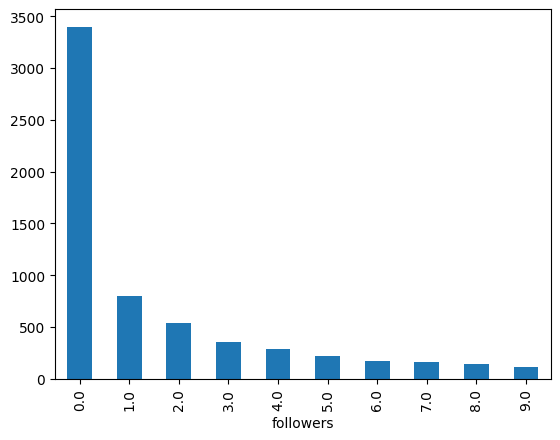

In [50]:
my_data_set.sig_field_df["followers"].value_counts(sort = True, ascending = False).head(10).plot(kind = "bar")

In [51]:
print(f"The most important problem here is majority of follower are 0 or almost 0, which create an imbalance in dataset, for example, even if I write a model to always predict follower as 0, it will still get {round(len(my_data_set.sig_field_df[my_data_set.sig_field_df['followers'] == 0])/len(my_data_set.sig_field_df), 2)} % correct.")

The most important problem here is majority of follower are 0 or almost 0, which create an imbalance in dataset, for example, even if I write a model to always predict follower as 0, it will still get 0.45 % correct.


A solution to fix this problem, is over sampling minority class using `SMOTE (Synthetic Minority Over-sampling Technique)`.

In [52]:
smote = SMOTE(sampling_strategy = "minority")

In [53]:
X_sm, y_sm = smote.fit_resample(X, y)

<Axes: xlabel='followers'>

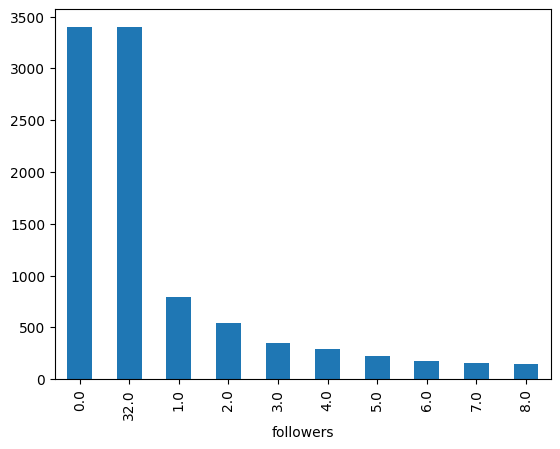

In [54]:
y_sm.value_counts(sort = True, ascending = False).head(10).plot(kind = "bar")

In [55]:
len(X), len(y), len(X_sm), len(y_sm)

(7178, 7178, 10570, 10570)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=0, stratify = y_sm)

In [57]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = X_train_scaled.copy()
X_test = X_test_scaled.copy()

In [58]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### Evaluate Improved Model

In [59]:
r_squared = model.score(X_test, y_test)

In [60]:
r_squared

0.7426404065880554

In [61]:
predicted_values = model.predict(X_test)

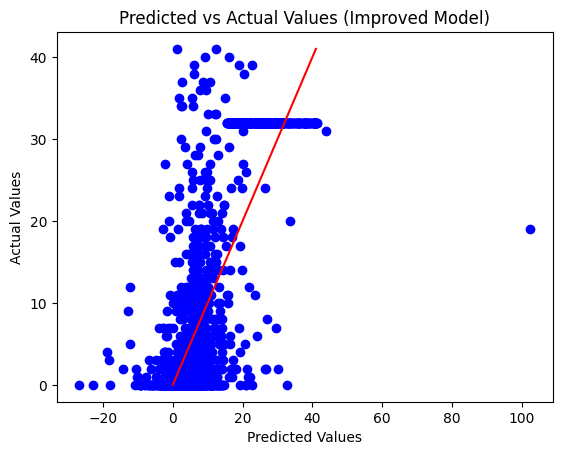

In [62]:
plt.scatter(predicted_values, y_test, color="blue")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Predicted vs Actual Values (Improved Model)")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red")
plt.show()

In [63]:
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=["Coefficient"])

coeff_df.head()
print("Top 20 Coefficient Variable")
coeff_df.sort_values(by = "Coefficient", ascending = False).head(20)

Top 20 Coefficient Variable


,Coefficient
following,6.564362
repo_Go,3.056426
public_gists,2.686093
starred_Assembly,2.646662
public_repos,2.635618
repo_CSS,2.590310
starred_TypeScript,2.466000
repo_JavaScript,1.188873
starred_JavaScript,0.861982
starred_C#,0.386870


## Plot Improved Model Residual

In [64]:
y_train_pred = model.predict(X_train)

In [65]:
residuals = y_train - y_train_pred

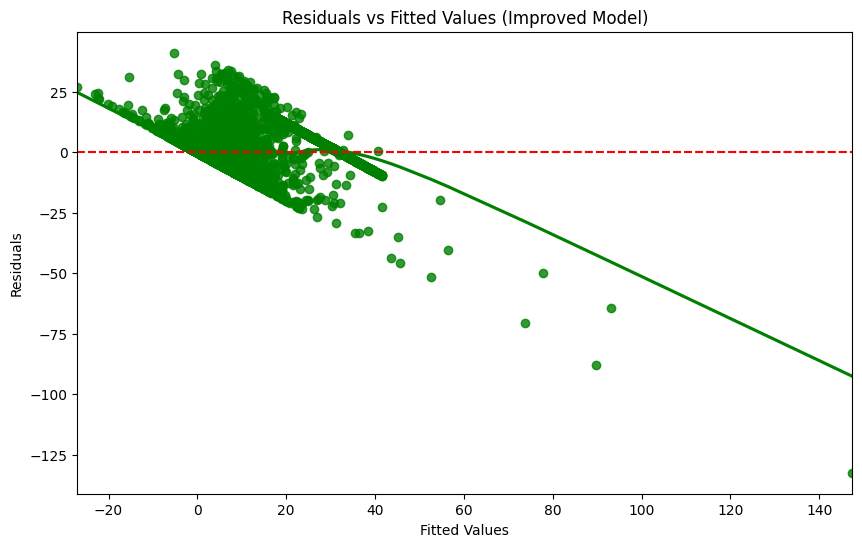

In [66]:
plt.figure(figsize=(10, 6))
sns.residplot(x=y_train_pred, y=residuals, lowess=True, color="g")
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values (Improved Model)")
plt.show()

There is still a trend in residual plot, which means there might be a non-linear relationship in dataset. Therefore, Proceed to change model to `Random Forest`

### Create Random Forest Model

In [67]:
model = RandomForestRegressor(n_estimators = 100, random_state = 0)

In [68]:
model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

### Evaluate Random Forest Model

In [69]:
r_squared = model.score(X_test, y_test)

In [70]:
r_squared

0.9115202698162215

In [71]:
predicted_values = model.predict(X_test)

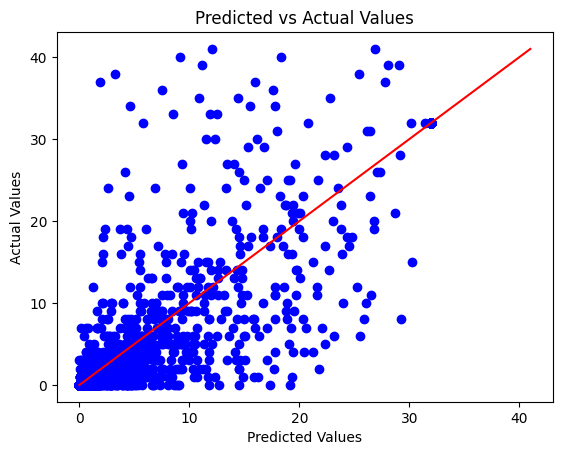

In [72]:
plt.scatter(predicted_values, y_test, color="blue")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Predicted vs Actual Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red")
plt.show()

In [73]:
y_train_pred = model.predict(X_train)

In [74]:
residuals = y_train - y_train_pred

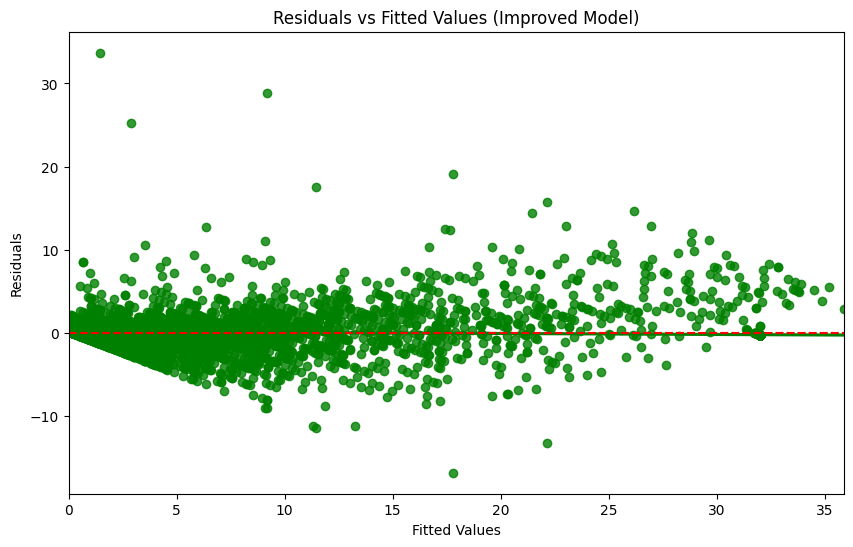

In [75]:
plt.figure(figsize=(10, 6))
sns.residplot(x = y_train_pred, y = residuals, lowess = True, color = "g")
plt.axhline(y = 0, color = "r", linestyle = "--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values (Improved Model)")
plt.show()

## Extract Insight from Fitted Model

In [76]:
importance_df = pd.DataFrame(model.feature_importances_, X.columns, columns = ["Importance"])
print("Top 20 Important Variables")
importance_df.sort_values(by = "Importance", ascending = False).head(20)

Top 20 Important Variables


,Importance
following,0.813310
repo_JavaScript,0.073147
repo_forks,0.027686
public_repos,0.022011
public_gists,0.010243
starred_topics,0.009738
repo_Java,0.007558
repo_description,0.006471
repo_topics,0.004515
repo_stargazers_count,0.001890


- **following**: This is the most important feature according to the model, with an importance of 0.813264. This suggests that the number of users one is following on GitHub is strongly associated with the number of followers one has. has.

- **repo_JavaScript**: This feature has the second highest importance score (0.073049). This suggests that having JavaScript repositories is associated with the number of followers a user has.


- **repo_forks**: This feature has an importance score of 0.027684, suggesting that the number of forks a repository has is associated with the number of followers a user has.


- **public_repos**: This feature has an importance score of 0.022064, suggesting that the number of public repositories a user has is associated with the number of followers they have.


- **public_gists**: This feature has an importance score of 0.010317, suggesting that the number of public gists a user has is associated with the number of followers they have.


The rest of the features have lower importance scores, but they still contribute to the model’s predictions. For example, `starred_topics`, `repo_Java`, and `repo_description` all have importance scores above `0.005`, suggesting they are somewhat associated with the number of followers a user has.